# Post-Processing Psuedo Surge Runs

In [2]:
import os 
import sys
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.colors as mcolors

plt.rcParams['text.usetex'] = False


In [25]:
fp      = '/Users/andrewnolan/OneDrive - Simon Fraser University (1sfu)/Harmonic_Beds_DataShare/R_0.01/*.nc'
files   = sorted(glob.glob(fp))
files.append(files.pop(1))

xarrays = []
for file in files:
    xarrays.append(xr.open_dataset(file))
    
mf_dataset = xr.concat(xarrays, 
                       pd.Index(np.arange(0,17), name='k'))

mf_dataset["H"] = mf_dataset.z_s - mf_dataset.z_b

In [30]:
import pint 
import numpy as np 
import matplotlib.pyplot as plt 

plt.rcParams['text.usetex'] = True

ureg = pint.UnitRegistry()

#############################################
# units
#############################################
a   = ureg.year             # [a]
s   = ureg.sec              # [s]
m   = ureg.meter            # [m]
kg  = ureg.kilogram         # [kg]
kPa = ureg('kPa')           # [kPa]
MPa = ureg('MPa')           # [MPa]

#############################################
# parameters (S.I. units)
#############################################
spy   = 365.25*24*60*60 * (s/a)                    # [s a^-1]
ρ     = 910             * (kg*m**-3)               # [Kg m^-3]
g     = 9.81            * (m*s**-2)                # [m s^-2]

#############################################
# parameters (Elmer/Ice)
#############################################
ρ     = ρ * (MPa/MPa.to_base_units()) * spy**-2    # [MPa m^-2 a^2] <--[Kg m^-3]
g     = g * spy**2       

In [70]:
alpha = mf_dataset.isel(k=0,t=0).z_s.differentiate('x').data * m/m
H     = mf_dataset.isel(k=0,t=0).H.data * m

In [71]:
tau_b = ρ * g * H * np.sin(alpha)
beta  = mf_dataset.isel(k=0,t=1).beta.data 

In [12]:
def smooth(x):
    """6-th order low-pass butterworth filter
    """
    import scipy.signal as signal
    sos = signal.butter(6, 1/1e3,'high', fs=1/50, output='sos')

    return signal.sosfiltfilt(sos, x)

smoothed = mf_dataset.z_s.isel(t=-1).groupby("k").map(smooth)

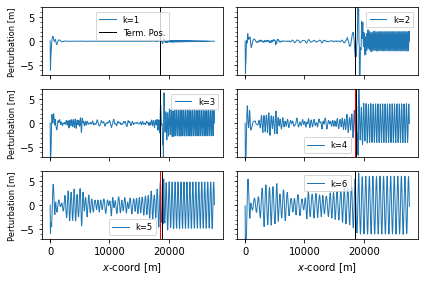

In [16]:
fig, axes = plt.subplots(3,2, sharex=True, sharey=True)

term_loc = (mf_dataset.z_s.isel(t=-1) - mf_dataset.z_b.isel(t=-1)).argmax('x').data

for i, ax in enumerate(axes.ravel()):
    
    pert = (mf_dataset.isel(k=i+1,t=-1).z_s - mf_dataset.isel(k=0,t=-1).z_s) 
    ax.plot(mf_dataset.x[::-1], smooth(pert), lw=1.0, label='k={}'.format(i+1))
    #ax.plot(mf_dataset.x[::-1], pert, lw=1.0, label='k={}'.format(i+1))
    
    if i == 0: 
        ax.axvline(mf_dataset.x[term_loc[i+1]], label='Term. Pos.', ls='-', color='k', lw=1.0)
    else:
        ax.axvline(mf_dataset.x[term_loc[0]], ls='-', color='r', lw=1.0)
        ax.axvline(mf_dataset.x[term_loc[i+1]], ls='-', color='k', lw=1.0)
    ax.legend(fontsize='small')
        
    if i % 2 == 0: 
        ax.set_ylabel('Perturbation [m]', fontsize='small')
    
    if i >= 4: 
        ax.set_xlabel('$x$-coord [m]')
        
axes[-1,-1].set_ylim(-7,7)
axes[-1,-1].set_yticks(np.arange(-7, 8), minor=True);
axes[-1,-1].set_xticks(np.arange(0, 29, 1), minor=True);

#fig.suptitle('No Highpass Filter')
plt.tight_layout()
plt.savefig('/Users/andrewnolan/Desktop/pert.png', dpi=400, bbox_inches='tight', facecolor='w')

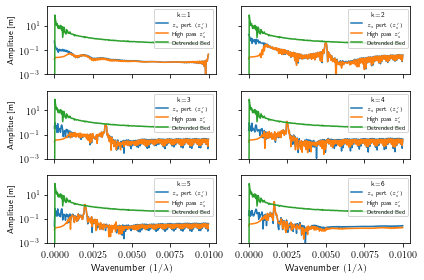

In [91]:
plt.rcParams['text.usetex'] = True

fig, axes = plt.subplots(3,2, sharex=True, sharey=True)

for i, ax in enumerate(axes.ravel()):
    
    pert = (mf_dataset.isel(k=i+1,t=-1).z_s - mf_dataset.isel(k=0,t=-1).z_s).data
    
    f_pert, pxx_pert = signal.periodogram(pert,                               
                                          fs=1/50, detrend=False,    scaling='spectrum')
    f_filt, pxx_filt = signal.periodogram(smooth(pert),                       
                                          fs=1/50, detrend=False,    scaling='spectrum')
    f_bed,  pxx_bed  = signal.periodogram(mf_dataset.isel(k=0,t=-1).z_b.data, 
                                          fs=1/50, detrend='linear', scaling='spectrum')

    ax.plot(f_pert, np.sqrt(pxx_pert), label='$z_{\\rm s}$ pert. ($z\'_{\\rm s}$)')
    ax.plot(f_filt, np.sqrt(pxx_filt), label='High pass $z\'_{\\rm s}$')
    ax.plot(f_bed,  np.sqrt(pxx_bed ), label='Detrended Bed')
    
    ax.legend(title='k={}'.format(i+1), fontsize='xx-small', title_fontsize='x-small')
    
    if i % 2 == 0: 
        ax.set_ylabel('Amplitue [m]', fontsize='small')
    
    if i >= 4: 
        ax.set_xlabel('Wavenumber $(1/\lambda)$')
        
axes[-1,-1].set_yscale('log')
axes[-1,-1].set_ylim(10e-4,None)

plt.tight_layout()
plt.savefig('/Users/andrewnolan/Desktop/pert_spectrum.png', dpi=400, bbox_inches='tight', facecolor='w')

plt.rcParams['text.usetex'] = False

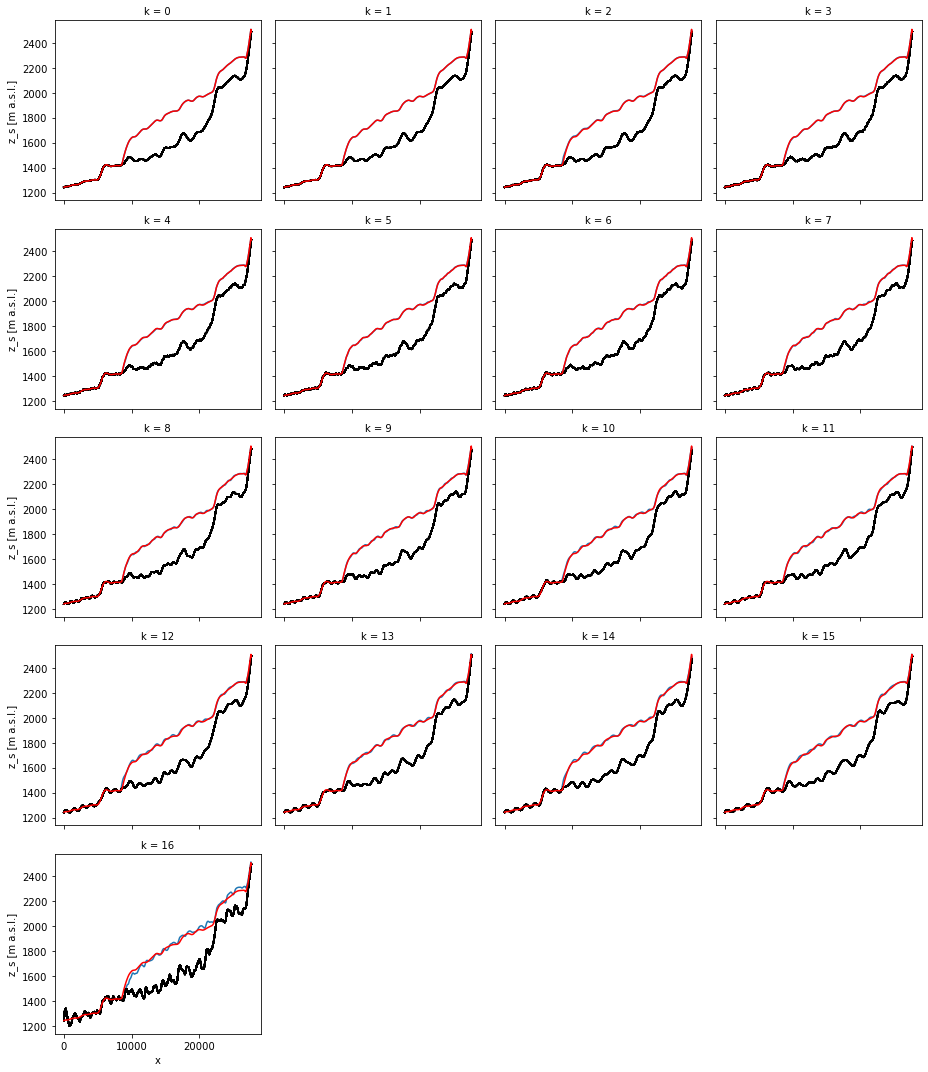

In [25]:
simple_line = mf_dataset.z_s.isel(t=-1).plot(
    x="x", hue="k", col="k", col_wrap=4
)

for i, ax in enumerate(simple_line.axes.ravel()):
    if i < len(mf_dataset.k):
        ax.plot(mf_dataset.x, mf_dataset.isel(k=i).z_b, color='k')
        ax.plot(mf_dataset.x, mf_dataset.isel(k=0, t=-1).z_s, color='r')
    
plt.savefig('/Users/andrewnolan/Desktop/smoothed_z_s_mean.png', dpi=400, bbox_inches='tight', facecolor='w')

# A nice animation: 

In [145]:
from matplotlib import animation, rc

plt.rcParams['text.usetex'] = True
plt.rcParams['animation.html'] = 'jshtml'

fp = '/Users/andrewnolan/Desktop/new_data/pseudo_k_02_10a_dt_0.1_dx_50_mb_2.02_off.nc'
Data = xr.open_dataset(fp)

In [146]:
fig, ax = plt.subplots(1,1,figsize=(6.6667,4))

ax.set_xlim(Data.x.min(), Data.x.max())
ax.set_ylim(Data.z_s.min()-25, Data.z_s.max()+200)
ax.set_ylabel('m a.s.l.')
ax.set_xlabel('x-coord (m)')

ax.plot( Data.x,Data.isel(t=0).z_b,color='saddlebrown')
ax.fill_between(Data.x, np.ones(Data.x.shape[0])*ax.get_ylim()[0], Data.isel(t=0).z_b, color='saddlebrown', alpha=0.5)

collection = ax.fill_between(Data.x, Data.isel(t=0).z_b, Data.isel(t=0).z_s, color='lightblue', alpha=0.5)

ax.plot(Data.x, Data.isel(t=0).z_s, 'k:', alpha=0.5, label='$z_s(t=0.0)$')
ax.legend()


ax.set_title(r'$z_{\rm b}(x) = z_{\rm b_{\rm F}} + \sum_{k=1}^{10} A_{k} \sin \left( \frac{2 \pi}{k \bar H} x \right)$')
ax.set_aspect(9)

line1, = ax.plot([], [], lw=2, color='lightblue', label='$z_s(t=0.0)$',)
line   = [line1]

def animate(i):
    if i == 0:
        ax.collections.clear()
        line[0].set_data(Data.x, Data.isel(t=i).z_s)
        line[0].set_label('$z_s(t={{{:.1f}}})$'.format(i/10))

        ax.fill_between(Data.x, np.ones(Data.x.shape[0])*ax.get_ylim()[0], Data.isel(t=0).z_b, color='saddlebrown', alpha=0.5)
        ax.fill_between(Data.x, Data.isel(t=0).z_b, Data.isel(t=0).z_s, color='lightblue', alpha=0.5)
        ax.legend()
    else:
        ax.collections.clear()
        line[0].set_label('$z_s(t={{{:.1f}}})$'.format(i/10))
        line[0].set_data(Data.x,  Data.isel(t=i).z_s)
        ax.fill_between(Data.x, np.ones(Data.x.shape[0])*ax.get_ylim()[0], Data.isel(t=i).z_b, color='saddlebrown', alpha=0.5)
        ax.fill_between(Data.x, Data.isel(t=i).z_b, Data.isel(t=i).z_s, color='lightblue', alpha=0.5)
    
        ax.legend()

    return line

anim = animation.FuncAnimation(fig, animate, 
                               frames=range(0,Data.t.shape[0]), interval=100, blit=True)

plt.tight_layout()
plt.close()
anim

In [ ]:
anim.save('/Users/andrewnolan/Desktop/animation.mp4', fps=10, dpi=800)

# VTU files:

In [142]:
import os
import meshio
import xarray as xr

In [150]:
# Find the files matching out run/step name
fp = '../Synthetic/perturbed_ratio-0.01/harmonics_02_H_100/VTU/*'

fn_list = sorted(glob.glob(fp))

In [147]:
def vm(vx, vy):
    """Calculate vel. magnitude from x and y component"""
    return np.sqrt(vx**2 + vy**2)

In [160]:
xgrid_cells = 554
ygrid_cells = 10


xgrid_pts   = xgrid_cells + 1
ygrid_pts   = ygrid_cells + 1

xnodes      = np.array(range(xgrid_pts))      # ynodes 
ynodes      = np.array(range(ygrid_pts))      # xnodes
tsteps      = np.array(range(len(fn_list)))   # number of time steps

timestep = [] #list of data arrays
for path in fn_list:
    t_val = fn_list.index(path)
    mesh = meshio.read(path, file_format= 'vtu') #mesh the file

    velx = mesh.point_data['velocity'][:,0].reshape((ygrid_pts,xgrid_pts)) #reshape the mesh coordinates
    vely = mesh.point_data['velocity'][:,1].reshape((ygrid_pts,xgrid_pts))
    velm = vm(velx,vely)
    
    xdim = mesh.points[:,0].reshape((ygrid_pts,xgrid_pts))
    ydim = mesh.points[:,1].reshape((ygrid_pts,xgrid_pts))

    tempdataset = xr.Dataset(data_vars = {'vel_x' : (('ynode','xnode'), velx) ,
                                          'vel_y' : (('ynode','xnode'), vely) ,
                                          'vel_m' : (('ynode','xnode'), velm)},
                             coords    = {'yvals' : (('ynode','xnode'), ydim),
                                          'xvals' : (('ynode','xnode'), xdim)})
    timestep.append(tempdataset)

datacomb = xr.concat(timestep, dim='t')

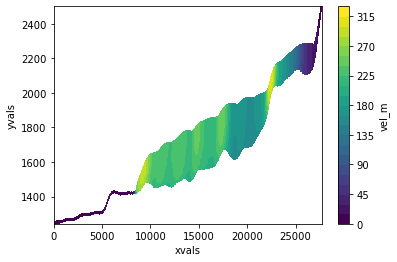

In [154]:
plt.rcParams['text.usetex'] = False

datacomb.sel(t=-1).vel_m.plot.contourf(x = 'xvals', y = 'yvals', levels=25)

In [159]:
fig, ax = plt.subplots(1,1,figsize=(6,3))

ims = []
for t in np.arange(0,100): 
    im = ax.pcolormesh(datacomb.sel(t=t).xvals, 
                       datacomb.sel(t=t).yvals, 
                       datacomb.sel(t=t).vel_m, 
                       clim = (0, 200),
                       shading='gouraud')
    ims.append([im])

fig.colorbar(im, ax=ax)

#ims = [[im] for im in ims]
anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.tight_layout()
plt.close()
anim

In [ ]:
datacomb.to_netcdf("/Users/andrewnolan/Desktop/test_xarray.nc")